## Importing Libraries

In [77]:
# Uncomment if running on Google Colab
#!pip install mne gdown

import mne
import scipy.io
import numpy as np
import pathlib
import gdown
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

## Downloading the zipped data file from Google Drive

In [11]:
cwd = pathlib.Path.cwd()

# Download zip file, if data folder doesn't exist
if not ((cwd/'data.zip').exists() or ((cwd/'data').exists and (cwd/'data').is_dir())):
    url = 'https://drive.google.com/file/d/1y5r8yVxDHqvHck1hsX6TIjnXRpOTP4RE/view?usp=sharing'
    output = 'data.zip'
    gdown.download(url, output, fuzzy=True)


# Extract zip file to the current working directory
if not ((cwd/'data').exists and (cwd/'data').is_dir()):
    with zipfile.ZipFile(cwd/'data.zip', 'r') as zip_ref:
        zip_ref.extractall(cwd)

    # Delete zip file
    (cwd/'data.zip').unlink()

## Importing data

In [12]:
# Get an array of file paths of each subject
directory = pathlib.Path('data')
files = directory.glob('*.mat')
file_paths = sorted([file for file in files if file.is_file()])


def create_folder(path):
    # Define the folder path
    folder_path = pathlib.Path(path)  # Replace this with the path to your folder

    # Check if the folder exists
    if not folder_path.exists():
        # If the folder doesn't exist, create it
        folder_path.mkdir(parents=True, exist_ok=True)
        print(f"Folder '{folder_path}' created successfully.")
    else:
        print(f"Folder '{folder_path}' already exists.")


## Processing Matlab data to Python data object

**Markers for Y**
1\. key press with left index finger

2\. key press with right index finger

3\. key press with left index finger

4\. key press with right index finger

5\. screen freeze

10\. init level

11\. next level

12\. Pacman avatar died

20\. start game

21\. end game

22\. start normal condition

23\. end normal condition

24\. start frustration condition

25\. end frustration condition

26\. start self assessment

27\. end self assessment

28\. start pause

29\. end pause

100–109\. valence response 

110–119\. arousal response 

120–129\. dominance response


In [180]:
def process_mat_file(file_path):
    mat = scipy.io.loadmat(file_path)

    chann = np.array([mat['chann'][0][i][0] for i in range(len(mat['chann'][0]))])
    X = mat['X']
    I = mat['I']
    Y = mat['Y'][0]

    mask = np.isin(chann, ['GSR2', 'Erg1', 'Erg2'], invert=True)

    chann = chann[mask]
    X = X[mask]


    id_lab = np.array([mat['id_lab'][0][i][0] for i in range(len(mat['id_lab'][0]))])

    return {'X': X, 'Y': Y, 'id_lab': id_lab, 'chann': chann, 'I': I}

# Example to obtain processed data from a file
# data = process_mat_file('data/S00.mat')
# data.keys()

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.20 Hz: -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


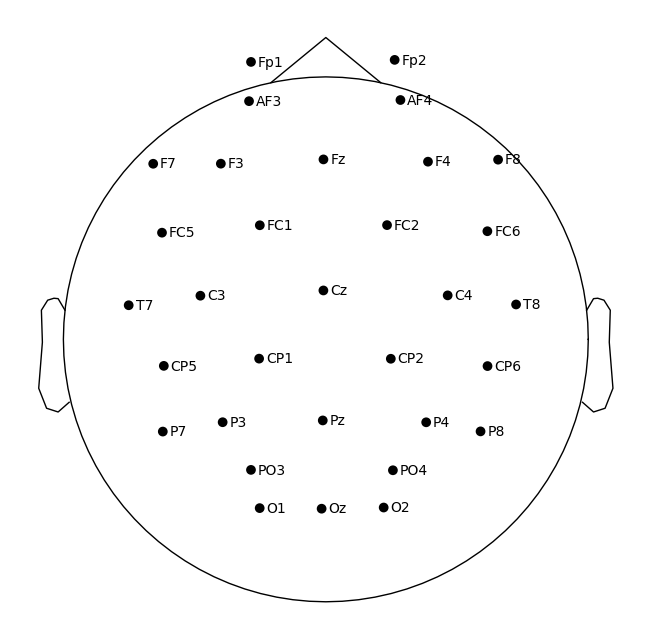

Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 129 original time points ...
0 bad epochs dropped
Not setting metadata
84 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 84 events and 129 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB



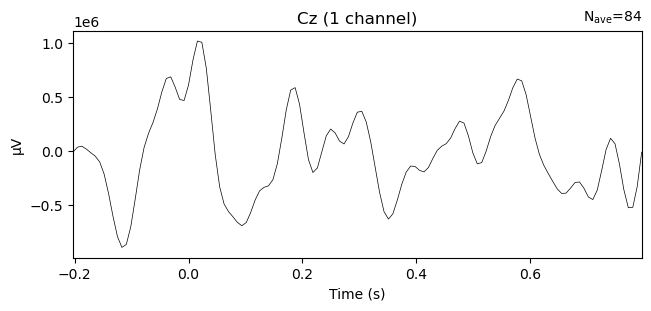

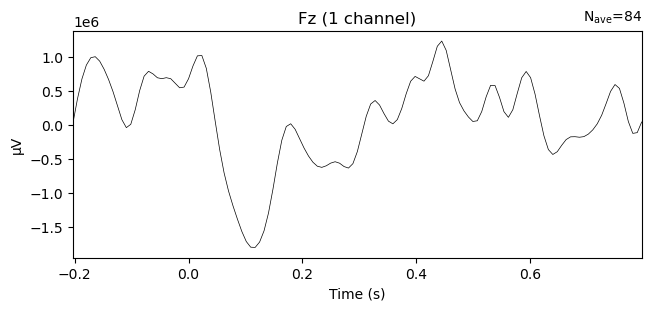

Need more than one channel to make topography for eeg. Disabling interactivity.


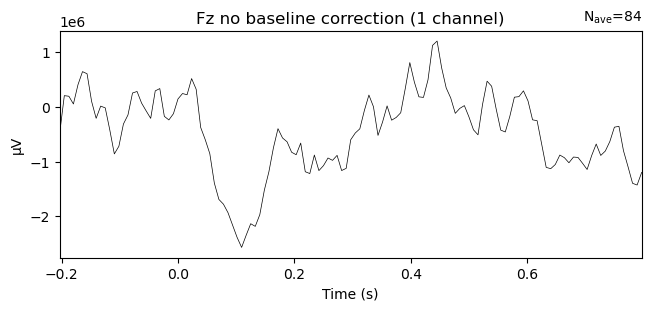

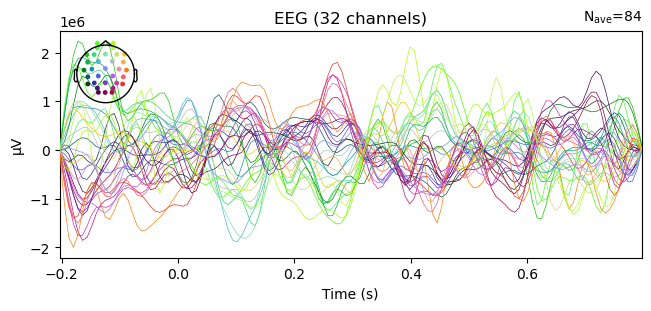

[[ 0.68325735 -1.12806634 -1.53275178 ...  2.40112108  1.47321645
   1.20064817]]


In [389]:
from mne.preprocessing import ICA

data = process_mat_file('data/S00.mat')

X = data['X']
Y = data['Y']
I = data['I']
id_lab = data['id_lab']
chann = data['chann']

loc_ignored_input = np.where((Y == 3) | (Y == 4))[0]

start_index = np.where(Y == 20)[0][0]

start_time = I[0, np.where(Y == 20)[0][0]]

sfreq = 128  # Sampling frequency (Hz)
n_channels = 44  # Number of channels
n_times = X.shape[1]  # Number of time points
ch_types = ['eeg'] * 32 + ['eog'] * 4 + ['emg'] * 4 + ['gsr'] + ['bio'] + ['resp'] + ['temperature']
info = mne.create_info(ch_names=list(chann), sfreq=sfreq, ch_types=ch_types)
montage = mne.channels.make_standard_montage('standard_1020')
info_electrodes = mne.create_info(ch_names=montage.ch_names, sfreq=info['sfreq'], ch_types='eeg')
info_electrodes.set_montage(montage)
info.set_montage(montage)
raw = mne.io.RawArray(X, info, verbose=0)

# raw = raw.crop(tmin=start_time)

# adding a high-pass filter of 0.2 Hz to remove low-frequency drift
raw = raw.filter(l_freq=0.2, h_freq=None, method="iir", picks="all", iir_params=None)

# adding notch filter to remove power line noise betwee 49-51 Hz
raw = raw.notch_filter([50], method='iir', verbose=True, iir_params=None, picks="all")
raw = raw.set_eeg_reference(ref_channels='average')

# corrected for eye movement using a regression based subtraction method
weights = mne.preprocessing.EOGRegression().fit(raw)
raw = weights.apply(raw, copy=False)

raw.plot_sensors(show_names=True)

# Create events for mne
events = []
for id, index in enumerate(loc_ignored_input):
    event = [int(index - np.round(0.1 * 128)), 0, id] # Seems to be a 100ms lag between labeling and event occuring by visual inspection? maybe shouldn't it cuz, i am playing god with the data
    events.append(event)

events = np.array(events)


# Create Epochs
tmin = -0.2  # 200ms before the event
tmax = 0.8  # 800ms after the event
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=None)
epochs_b = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=(tmin, 0))

# epochs.compute_psd(fmin=0.2, fmax=40.0).plot(average=True, picks="data", exclude="bads")

# # # Compute Average
evoked = epochs.average()
evoked_b = epochs_b.average()

evoked.filter(l_freq=1, h_freq=20, method="iir")

evoked.plot(picks="Cz", titles="Cz", verbose=0)
evoked.plot(picks="Fz", titles="Fz", verbose=0)
evoked_b.plot(picks="Fz", titles="Fz no baseline correction")
evoked.plot(verbose=0)

Cz_data = raw.pick("Cz").get_data()

print(Cz_data)

# raw.crop(tmin=start_time)
# raw.plot(scalings="auto")

In [371]:
period_of_loc = list(zip(np.where(data['Y'] == 24)[0], np.where(data['Y'] == 25)[0]))

period_of_norm = list(zip(np.where(data['Y'] == 22)[0], np.where(data['Y'] == 23)[0]))

id_lab

array(['time', 'block', 'frustration-condition', 'valence', 'arousal',
       'dominance'], dtype='<U21')

## Confirming that screen freezes occur with a 5% probability
Game was played at 25 frames per second. Thats a total of 3000 frames in a 2min LOC block.

In [181]:
loc_freeze_indices = np.where(Y == 5)[0]

arr_count = []

for i in period_of_loc:
    count = 0
    for j in loc_freeze_indices:
        if j >= i[0] and j <= i[1]:
            count += 1
    arr_count.append(count)

arr_count = np.array(arr_count)

(arr_count / 3000) * 100

array([5.3       , 5.76666667, 5.46666667, 4.66666667, 4.46666667])

In [158]:
len(chann)

44

## Plotting ERP data for ignored inputs

Not setting metadata
114 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 114 events and 91 original time points ...
0 bad epochs dropped


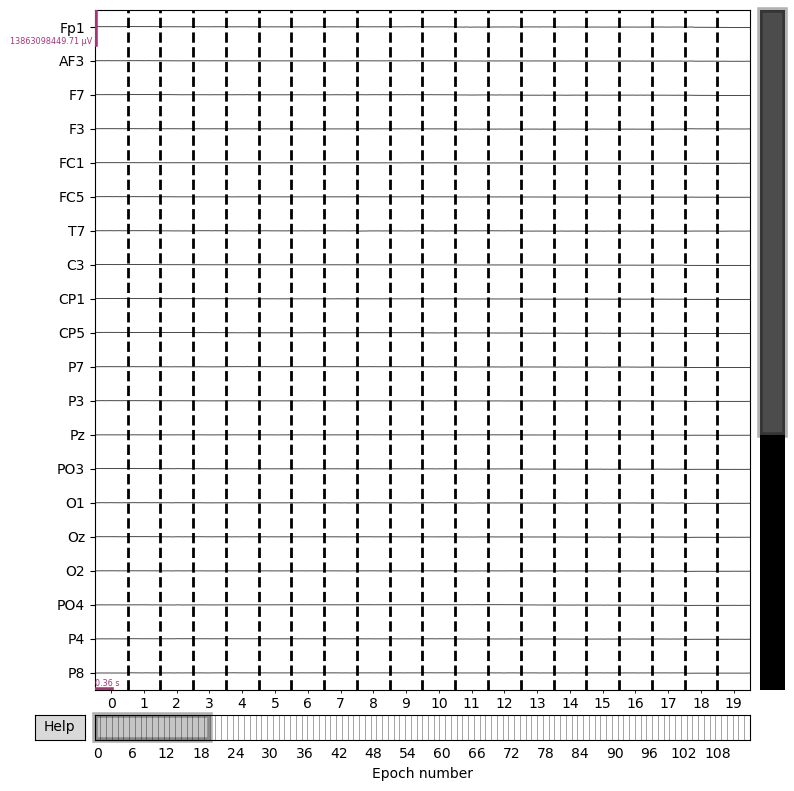

<RawArray | 4 x 248832 (1944.0 s), ~7.6 MB, data loaded>


In [202]:
data = process_mat_file('data/S04.mat')

X = data['X']
Y = data['Y']
I = data['I']
id_lab = data['id_lab']
chann = data['chann']

sfreq = 128  # Sampling frequency (Hz)
n_channels = 44  # Number of channels
n_times = X.shape[1]  # Number of time points
ch_types = ['eeg'] * 32 + ['eog'] * 4 + ['emg'] * 4 + ['gsr'] + ['bio'] + ['resp'] + ['temperature']
info = mne.create_info(ch_names=list(chann), sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(X, info, verbose=0)

loc_left_indices = np.where(Y == 3)[0]
loc_right_indices = np.where(Y == 4)[0]
loc_freeze_indices = np.where(Y == 5)[0]

loc_ignored_input = np.where((Y == 3) | (Y == 4))[0]

# raw = raw.notch_filter([50], method='iir', verbose=True)
# raw = raw.filter(l_freq=0.2, h_freq=None, method="iir")
# raw.set_eeg_reference(ref_channels='average')

# weights = mne.preprocessing.EOGRegression().fit(raw)
# raw = weights.apply(raw, copy=True)


# Create events for mne
events = []
for id, index in enumerate(loc_ignored_input):
    event = [index, 0, id]
    events.append(event)

events = np.array(events)
# raw.pick([chann[30]]).plot(scalings="auto", events=events)

# # print(loc_left_indices.shape, loc_right_indices.shape)

# # # Create Epochs
tmin = -0.2  # 200ms before the event
tmax = 0.5  # 500ms after the event
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, preload=True, baseline=None)

# epochs.compute_psd(fmin=0.2, fmax=40.0).plot(average=True, picks="data", exclude="bads")

# # # Compute Average
evoked = epochs.average()


# evoked.plot(picks=chann[30], titles=chann[30], verbose=0)
# # # # Plot each channel's ERPs
# for i in chann[31]:
#     fig = evoked_smooth.plot(picks=i, titles=i, verbose=0)
#     fig.savefig('plots/S00_loc_left_avg_' + i + '.png')

eog_channels = raw.pick(['eog'])
print(eog_channels)

## Creating Epochs

Creating RawArray with float64 data, n_channels=32, n_times=242569
    Range : 0 ... 242568 =      0.000 ...  1617.120 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 495 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


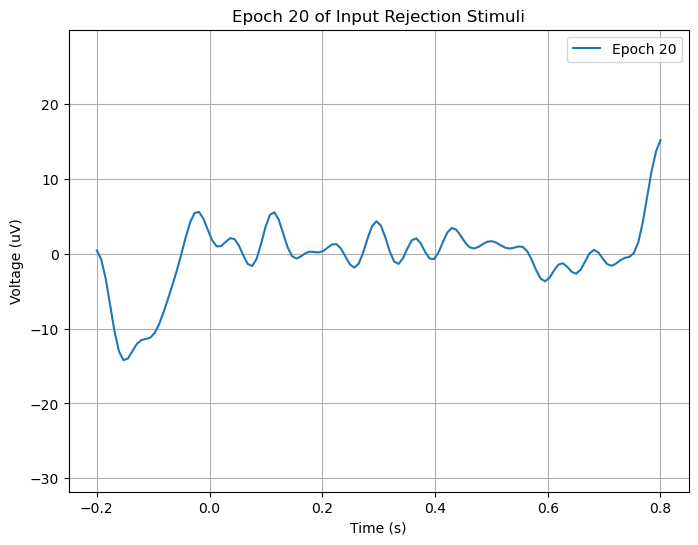

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import mne

# Load data from the file S00.mat
mat_data = scipy.io.loadmat('data/S00.mat')

# Extract the EEG data X, Y, and I
X = mat_data['X'][:32, 3191:]  # Use only the first 32 rows and columns after 3191
Y = mat_data['Y'][0, 3191:]
I = mat_data['I'][0, 3191:]

# Define the event codes (Y values) for ERPs
event_codes = [3,4]

# Set values in Y outside the event codes to 0
Y_events = np.where(np.isin(Y, event_codes), Y, 0)

# Find the indices where Y equals the event codes
event_indices = np.where(Y_events > 0)[0]

# Define the time window around each event (in seconds)
time_window_before = 0.2  # 200 milliseconds before event
time_window_after = 0.8  # 800 milliseconds after event

# Filter EEG data with MNE
sfreq = 150  # Sampling frequency in Hz, you might need to change this
low_freq = 1  # Low pass frequency
high_freq = 20  # High pass frequency

# Create MNE info structure
info = mne.create_info(ch_names=[f'EEG{i+1}' for i in range(X.shape[0])], sfreq=sfreq, ch_types='eeg')

# Create MNE RawArray object
raw = mne.io.RawArray(X, info)

# Filter the data
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

# Get the filtered data from MNE RawArray
X_filtered = raw.get_data()

# Calculate the average EEG across the selected channels
average_eeg = np.mean(X_filtered, axis=0)

# Calculate the min and max of the average EEG for scaling
eeg_min = np.min(average_eeg)
eeg_max = np.max(average_eeg)

# Randomly select 1 indices for plotting
num_plots = 1
random_indices = np.random.choice(event_indices, num_plots, replace=False)

# Iterate through the randomly selected indices
for i, random_index in enumerate(random_indices):
    # Extract the EEG readings (X) for the random event within the time window using the average EEG
    window_start = I[random_index] - time_window_before
    window_end = I[random_index] + time_window_after
    window_indices = np.where((I >= window_start) & (I <= window_end))[0]
    random_event_eeg = average_eeg[window_indices]

    # Calculate the time points for the ERP waveform
    time_points = np.linspace(-time_window_before, time_window_after, len(random_event_eeg))

    # Get the index of the random epoch in event_indices
    random_event_index = np.where(event_indices == random_index)[0][0]

    # Plot the single random event with Average EEG Data (scaled)
    plt.figure(figsize=(8, 6))
    plt.plot(time_points, random_event_eeg, label=f'Epoch {random_event_index + 1}')  # Use random_event_index for title and legend
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (uV)')
    plt.title(f'Epoch {random_event_index + 1} of Input Rejection Stimuli')  # Title with index from event_indices
    plt.ylim(eeg_min, eeg_max)  # Set y-axis limits
    plt.legend()
    plt.grid(True)
    plt.show()


## ERP Response

Creating RawArray with float64 data, n_channels=32, n_times=242569
    Range : 0 ... 242568 =      0.000 ...  1617.120 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 495 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


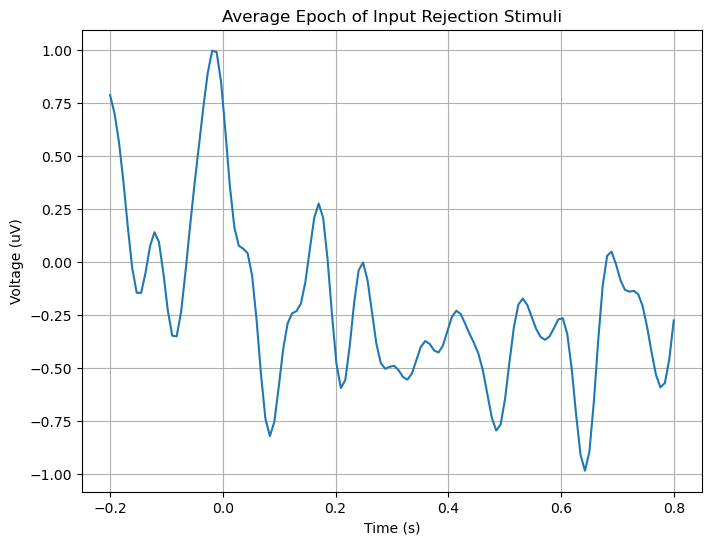

[[ 2.21457818  2.78835657  3.14593737 ... -1.23779245 -0.39077862
   0.41382975]
 [ 1.63760913  2.05108438  2.28316876 ... -0.44170567 -0.17167555
   0.32746871]
 [ 1.45991605  1.46288481  1.51822557 ...  0.60465588  0.90081989
   1.08499534]
 ...
 [ 2.83182808  3.58296534  4.21508068 ... -0.86399598 -0.00991669
   0.93622468]
 [ 1.07003786  1.31652915  1.40041305 ... -0.95892153 -0.74254965
  -0.38909714]
 [ 0.19789797  0.25731155  0.21599822 ... -0.23645984 -0.1612529
  -0.05429257]]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import mne

# Load data from the file S00.mat
mat_data = scipy.io.loadmat('data/S00.mat')

# Extract the EEG data X, Y, and I
X = mat_data['X'][:32, 3191:]  # Use only the first 32 rows and columns after 3191
Y = mat_data['Y'][0, 3191:]
I = mat_data['I'][0, 3191:]

# Define the event codes (Y values) for ERPs
event_codes = [3,4]

# Set values in Y outside the event codes to 0
Y_events = np.where(np.isin(Y, event_codes), Y, 0)

# Find the indices where Y equals the event codes
event_indices = np.where(Y_events > 0)[0]

# Define the time window around each event (in seconds)
time_window_before = 0.2  # 200 milliseconds before event
time_window_after = 0.8  # 800 milliseconds after event

# Filter EEG data with MNE
sfreq = 150  # Sampling frequency in Hz, you might need to change this
low_freq = 1  # Low pass frequency
high_freq = 20  # High pass frequency

# Create MNE info structure
info = mne.create_info(ch_names=[f'EEG{i+1}' for i in range(X.shape[0])], sfreq=sfreq, ch_types='eeg')

# Create MNE RawArray object
raw = mne.io.RawArray(X, info)

# Filter the data
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

# Get the filtered data from MNE RawArray
X_filtered = raw.get_data()

# Calculate the min and max of the average EEG for scaling
eeg_min = np.min(X_filtered)
eeg_max = np.max(X_filtered)

# Accumulate EEG data for all epochs
all_epochs_eeg = []

# Iterate through all event indices
for event_index in event_indices:
    # Extract the EEG readings (X) for each event within the time window using the filtered EEG data
    window_start = I[event_index] - time_window_before
    window_end = I[event_index] + time_window_after
    window_indices = np.where((I >= window_start) & (I <= window_end))[0]
    event_eeg = X_filtered[:, window_indices]

    # Append the event EEG to the list
    all_epochs_eeg.append(event_eeg)

# Convert the list to a numpy array
all_epochs_eeg = np.array(all_epochs_eeg)

# Calculate the average EEG across all epochs
average_epoch_eeg = np.mean(all_epochs_eeg, axis=0)

# Calculate the time points for the ERP waveform
time_points = np.linspace(-time_window_before, time_window_after, average_epoch_eeg.shape[1])

# Plot the average epoch
plt.figure(figsize=(8, 6))
plt.plot(time_points, np.mean(average_epoch_eeg, axis=0))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Average Epoch of Input Rejection Stimuli')
# plt.ylim(eeg_min, eeg_max)  # Set y-axis limits
plt.grid(True)
plt.show()
print(average_epoch_eeg)

## Show average Beta Wave during stimuli during first half vs second half of experiment

Creating RawArray with float64 data, n_channels=32, n_times=242569
    Range : 0 ... 242568 =      0.000 ...  1617.120 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 153 samples (1.020 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


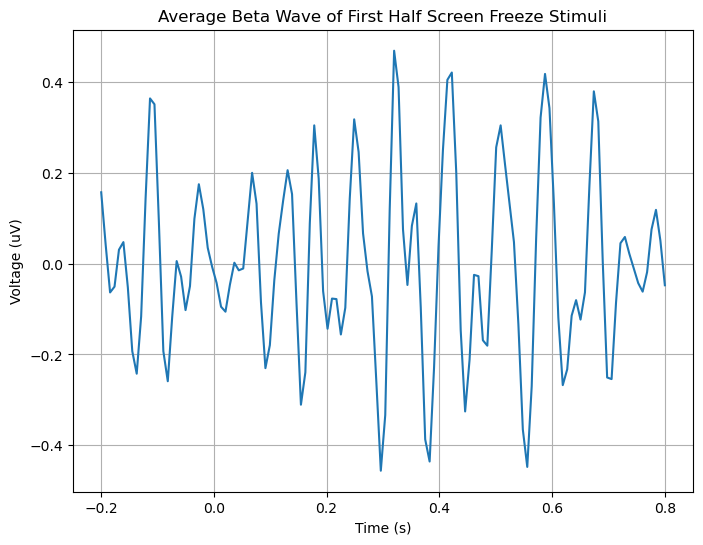

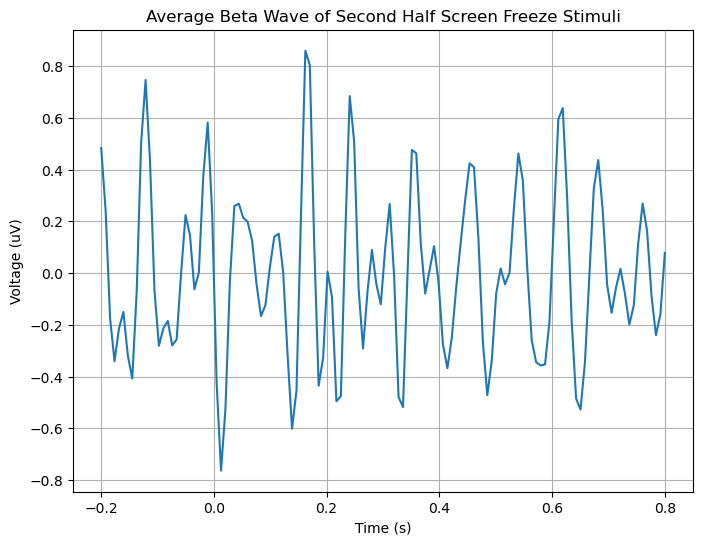

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import mne

# Load data from the file S00.mat
mat_data = scipy.io.loadmat('data/S00.mat')

# Extract the EEG data X, Y, and I
X = mat_data['X'][:32, 3191:]  # Use only the first 32 rows and columns after 3191
Y = mat_data['Y'][0, 3191:]
I = mat_data['I'][0, 3191:]

# Define the event codes (Y values) for ERPs
event_codes = [3,4]

# Set values in Y outside the event codes to 0
Y_events = np.where(np.isin(Y, event_codes), Y, 0)

# Find the indices where Y equals the event codes
event_indices = np.where(Y_events > 0)[0]

# Define the time window around each event (in seconds)
time_window_before = 0.2  # 200 milliseconds before event
time_window_after = 0.8  # 800 milliseconds after event

# Filter EEG data with MNE
sfreq = 150  # Sampling frequency in Hz, you might need to change this
low_freq = 13  # Lower bound of beta frequency range
high_freq = 30  # Upper bound of beta frequency range

# Create MNE info structure
info = mne.create_info(ch_names=[f'EEG{i+1}' for i in range(X.shape[0])], sfreq=sfreq, ch_types='eeg')

# Create MNE RawArray object
raw = mne.io.RawArray(X, info)

# Filter the data for beta waves
raw.filter(l_freq=low_freq, h_freq=high_freq, fir_design='firwin')

# Get the filtered data from MNE RawArray
X_filtered = raw.get_data()

# Calculate the min and max of the beta wave for scaling
beta_min = np.min(X_filtered)
beta_max = np.max(X_filtered)

# Divide the epochs into two halves
num_epochs = len(event_indices)
half_epoch = num_epochs // 2

# First Half
first_half_epochs = event_indices[:half_epoch]
all_epochs_beta_first = []

# Iterate through the first half event indices
for event_index in first_half_epochs:
    # Extract the beta wave readings (X) for each event within the time window using the filtered beta wave data
    window_start = I[event_index] - time_window_before
    window_end = I[event_index] + time_window_after
    window_indices = np.where((I >= window_start) & (I <= window_end))[0]
    event_beta = X_filtered[:, window_indices]

    # Append the event beta wave to the list
    all_epochs_beta_first.append(event_beta)

# Convert the list to a numpy array
all_epochs_beta_first = np.array(all_epochs_beta_first)

# Calculate the average beta wave for the first half
average_beta_epoch_first = np.mean(all_epochs_beta_first, axis=0)

# Calculate the time points for the beta wave
time_points_beta = np.linspace(-time_window_before, time_window_after, average_beta_epoch_first.shape[1])

# Plot the average beta wave for the first half
plt.figure(figsize=(8, 6))
plt.plot(time_points_beta, np.mean(average_beta_epoch_first, axis=0))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Average Beta Wave of First Half Screen Freeze Stimuli')
# plt.ylim(beta_min, beta_max)  # Set y-axis limits
plt.grid(True)
plt.show()

# Second Half
second_half_epochs = event_indices[half_epoch:]
all_epochs_beta_second = []

# Iterate through the second half event indices
for event_index in second_half_epochs:
    # Extract the beta wave readings (X) for each event within the time window using the filtered beta wave data
    window_start = I[event_index] - time_window_before
    window_end = I[event_index] + time_window_after
    window_indices = np.where((I >= window_start) & (I <= window_end))[0]
    event_beta = X_filtered[:, window_indices]

    # Append the event beta wave to the list
    all_epochs_beta_second.append(event_beta)

# Convert the list to a numpy array
all_epochs_beta_second = np.array(all_epochs_beta_second)

# Calculate the average beta wave for the second half
average_beta_epoch_second = np.mean(all_epochs_beta_second, axis=0)

# Plot the average beta wave for the second half
plt.figure(figsize=(8, 6))
plt.plot(time_points_beta, np.mean(average_beta_epoch_second, axis=0))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Average Beta Wave of Second Half Screen Freeze Stimuli')
# plt.ylim(beta_min, beta_max)  # Set y-axis limits
plt.grid(True)
plt.show()


## Show Emotion Scale Over Experiment

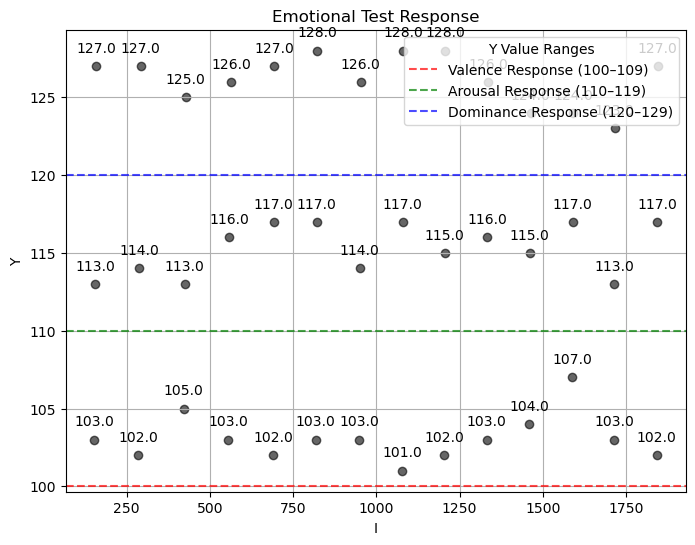

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Load data from the file S00.mat
mat_data = scipy.io.loadmat('data/S00.mat')

# Extract the Y and I data
Y = mat_data['Y'][0, 3191:]
I = mat_data['I'][0, 3191:]

# Find indices where Y is above 99
above_99_indices = np.where(Y > 99)[0]

# Extract Y and I values where Y is above 99
Y_above_99 = Y[above_99_indices]
I_above_99 = I[above_99_indices]

# Plot Y values over corresponding I values where Y is above 99
plt.figure(figsize=(8, 6))
plt.scatter(I_above_99, Y_above_99, color='black', alpha=0.6)

# Annotate each point with its corresponding Y value
for i, (x, y) in enumerate(zip(I_above_99, Y_above_99)):
    label = f'{y:.1f}'
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Add legend for the ranges of Y values
plt.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Valence Response (100–109)')
plt.axhline(y=110, color='green', linestyle='--', alpha=0.7, label='Arousal Response (110–119)')
plt.axhline(y=120, color='blue', linestyle='--', alpha=0.7, label='Dominance Response (120–129)')

plt.xlabel('I')
plt.ylabel('Y')
plt.title('Emotional Test Response')
plt.legend(title='Y Value Ranges', loc='upper right')
plt.grid(True)
plt.show()


## Changed event to screen freeze